## Importing required libraries

In [110]:
import json
import math
import os
import random

import numpy as np
import pandas as pd
from PIL import Image
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
%matplotlib inline

from keras import Model, Sequential
from keras.activations import softmax
from keras.applications.inception_v3 import InceptionV3, decode_predictions, preprocess_input
from keras.layers import (Activation, Bidirectional, Concatenate, Dense, Embedding,
                          LSTM, RepeatVector, Input)

from tensorflow.keras import initializers, optimizers
from tensorflow.keras.layers import (BatchNormalization, Dense, Dropout, Embedding, Flatten, LSTM,
                                      MaxPooling2D, Reshape, SpatialDropout1D, concatenate, multiply)
from tensorflow.keras.regularizers import l1, l1_l2, l2
from tensorflow.keras.utils import to_categorical

In [4]:
train_data_annotations = r"abstract_v002_train2015_annotations.json"  #Loading the train_annotations data in json format and creating a dataframe for it.
annotation_data = json.load(open(train_data_annotations))
annotation_train = pd.DataFrame(annotation_data["annotations"])
annotation_train.head()

question_type multiple_choice_answer  \
0           who                    man   
1  where is the                blanket   
2  where is the                  bench   
3       is this                    yes   
4  what kind of                   soda   

                                             answers  image_id answer_type  \
0  [{'answer': 'old person', 'answer_confidence':...     11779       other   
1  [{'answer': 'on blanket', 'answer_confidence':...     11779       other   
2  [{'answer': 'on bench', 'answer_confidence': '...     11779       other   
3  [{'answer': 'yes', 'answer_confidence': 'yes',...      5536      yes/no   
4  [{'answer': 'water', 'answer_confidence': 'no'...      5536       other   

   question_id  
0       117792  
1       117790  
2       117791  
3        55360  
4        55361

In [5]:
mcq_value=pd.DataFrame(annotation_train['multiple_choice_answer'].value_counts())
print(mcq_value.to_string())

                                                   multiple_choice_answer
yes                                                                 14314
no                                                                  10143
2                                                                    3496
1                                                                    1934
red                                                                  1506
3                                                                    1373
white                                                                 789
yellow                                                                603
blue                                                                  603
4                                                                     599
dog                                                                   538
brown                                                                 517
0                                     

In [6]:
train_mcq = "MultipleChoice_abstract_v002_train2015_questions.json"  #Loading the mcq_train data and extracting the questions columns
mcq_data = json.load(open(train_mcq))
mcq_train = pd.DataFrame(mcq_data["questions"])
mcq_train.head()

image_id                     question  \
0     11779           Who looks happier?   
1     11779  Where is the woman sitting?   
2     11779    Where is the man sitting?   
3      5536          Is this man hungry?   
4      5536  What kind of drink is that?   

                                    multiple_choices  question_id  
0  [alive, 1, woman, purple, 2, yes, white, boy, ...       117792  
1  [3, no, blue, red, 1, slide, monkey bars, jump...       117790  
2  [away, yes, blue, 1, 2, mouse, couch, no, yell...       117791  
3  [water, yellow, 4, running, blue, pouring, out...        55360  
4  [wine, girl would fall, soda, white, yes, coke...        55361

Functions to generate file name from image_ids.

In [7]:
def zero_append(id):
    arr = ["0","0","0","0","0","0","0","0","0","0","0","0"]  #The number of zeros taken in a image id is considered in a array string
    count = 0
    for i in range(len(id)-1, -1,-1):
        arr[count] = id[i]
        count += 1
    return "".join(arr[::-1])
    
def check_fname(image_id, type = 't'): #checking with file name and if it matches it will select the image id of the corresponding file
    img_id = str(image_id)
    if type == 't':
        file_name = "abstract_v002_train2015_"
    else:
        file_name = "abstract_v002_val2015_"
    s = zero_append(img_id)
    return file_name + s + ".png"

Join the annotations and questions dataframe on baiss of question_id and then select columns that are required for training.

In [8]:
df_train = annotation_train.merge(mcq_train, how='inner', on='question_id')
df_train = df_train[['image_id_x', 'question', 'multiple_choice_answer']]
df_train.head()

image_id_x                     question multiple_choice_answer
0       11779           Who looks happier?                    man
1       11779  Where is the woman sitting?                blanket
2       11779    Where is the man sitting?                  bench
3        5536          Is this man hungry?                    yes
4        5536  What kind of drink is that?                   soda

In [11]:
df_dummy = pd.DataFrame(columns=['image_id_x', 'question', 'multiple_choice_answer'])
for i in range(len(df_train)): #only extracting the multiple choice answers that have numerical value
    try:
        x = int(df_train['multiple_choice_answer'].iloc[i])
        df_dummy = pd.concat([df_dummy, df_train.iloc[[i]]]) #concatenating the data frame with location of the multiple choice answer
    except:
        continue

In [12]:
df_dummy.head()

image_id_x                                question multiple_choice_answer
22      10005                       How many pillows?                      2
24       1527        How many people are in the room?                      1
36      15492  How many bushes are in the background?                      3
40       1329             How many logs on the grass?                      2
43      14657             How many mice are crawling?                      3

In [13]:
df_dummy['Image_path'] = ""
for i in range(len(df_dummy)):
    df_dummy['Image_path'].iloc[i] = "images/" + check_fname(df_dummy['image_id_x'].iloc[i]) #creating an image path column that has the location of the resppective pnd format files

In [14]:
df_dummy.head()

image_id_x                                question multiple_choice_answer  \
22      10005                       How many pillows?                      2   
24       1527        How many people are in the room?                      1   
36      15492  How many bushes are in the background?                      3   
40       1329             How many logs on the grass?                      2   
43      14657             How many mice are crawling?                      3   

                                         Image_path  
22  images/abstract_v002_train2015_000000010005.png  
24  images/abstract_v002_train2015_000000001527.png  
36  images/abstract_v002_train2015_000000015492.png  
40  images/abstract_v002_train2015_000000001329.png  
43  images/abstract_v002_train2015_000000014657.png

In [15]:
df_dummy.drop('image_id_x',axis=1)  #dropping the img id columns as we dont need it our training

question multiple_choice_answer  \
22                               How many pillows?                      2   
24                How many people are in the room?                      1   
36          How many bushes are in the background?                      3   
40                     How many logs on the grass?                      2   
43                     How many mice are crawling?                      3   
...                                            ...                    ...   
59943                            How many animals?                      4   
59950               How many logs are on the fire?                      2   
59964          How many apples fell on the ground?                      3   
59984                    How many trees are there?                      0   
59991  How many pillows are on the chair and sofa?                      4   

                                            Image_path  
22     images/abstract_v002_train2015_000000010005.png  
24     images/abstract_v002_train2015_000000001527.png  
36     images/abstract_v002_train2015_000000015492.png  
40     images/abstract_v002_train2015_000000001329.png  
43     images/abstract_v002_train2015_000000014657.png  
...                                                ...  
59943  images/abstract_v002_train2015_000000016680.png  
59950  images/abstract_v002_train2015_000000006708.png  
59964  images/abstract_v002_train2015_000000006396.png  
59984  images/abstract_v002_train2015_000000016809.png  
59991  images/abstract_v002_train2015_000000012091.png  

[8623 rows x 3 columns]

In [17]:
df_train = df_dummy

images/abstract_v002_train2015_000000018130.png
Image path: images/abstract_v002_train2015_000000018130.png
Image size: (400, 700, 4)


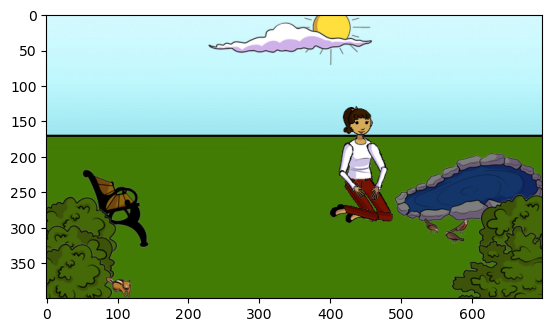

The Question is : How many clouds are on the sky?
The answer is : 1


In [23]:
import numpy as np
import os
import matplotlib.pyplot as plt
from PIL import Image

row_no = 20 #This picks a training question from the train dataset of 60000
img_name = df_train.iloc[row_no]['Image_path']
print(img_name)
image = Image.open(os.path.join(img_name))
print("Image path: " +img_name)
print("Image size: " +str(np.asarray(image).shape))
plt.imshow(image)
plt.show()

print("The Question is : " + df_train.iloc[row_no]["question"])
print("The answer is : " + df_train.iloc[row_no]["multiple_choice_answer"])


In [24]:
def read_image(image_name):
    image = Image.open(os.path.join(image_name))
    image = image.convert('RGB')  # converting the images to RGB format
    my_arr = np.asarray(image.resize((224,224))) / 255.0
    return my_arr[None, :]

In [25]:
import tensorflow as tf

vgg_model = tf.keras.applications.vgg16.VGG16(weights='imagenet')
VGG16Model = Model(inputs=vgg_model.inputs, outputs=vgg_model.layers[-2].output)

In [26]:
VGG16Model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [27]:
row_no = 502
img_name = df_train.iloc[row_no]['Image_path'] #reading the image from the path and predicting using VGG16
image = read_image(img_name)
encoded_image = VGG16Model.predict(image)
print(encoded_image.shape)

2023-05-09 20:20:14.580481: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


1/1 [==============================] - 0s 425ms/step
(1, 4096)


In [29]:
train_file = df_train["Image_path"].drop_duplicates().values
print(train_file[5])

images/abstract_v002_train2015_000000015616.png


In [30]:
def generate_image(img_list):
    for img in img_list:
        output = read_image(img)
        yield output

In [31]:
train_encoder = VGG16Model.predict(generate_image(train_file), steps=len(train_file), verbose=1)

7490/7490 [==============================] - 2198s 293ms/step


In [33]:
print(train_encoder.shape)
np.save("encoded_images_train_VGG.npy", train_encoder)

(7490, 4096)


## An LSTM with word2vec to encodes each word in the question qi:

In [54]:
max_len = 0
for i in df_train['question'].values:
    if len(i.split(" ")) > max_len:
        max_len = len(i.split(" "))
print(max_len)

17


In [53]:
def ques_equivate_len(ques_arr):
    ret_arr = []
    for i in range(18):
        try:
            if ques_arr[i] != " ":
                ret_arr.append(ques_arr[i])
            else:
                ret_arr.append("#")
        except:
            ret_arr.append("#")
    return ret_arr

In [35]:
# Generating a list that contains all questions and multiple choices
train_list_question = df_train['question'].values
train_list_mcq = df_train['multiple_choice_answer'].drop_duplicates().values

sample = set()
for some_question in train_list_question:
    words = some_question.lower().split(" ")
    for i in words:
        sample.add(i)

print(len(sample))

for ans in train_list_mcq:
    sample.add(ans)
print(len(sample))

sample.add("#")

print(len(sample))

some_list = list(sample)
some_list.sort()

1454
1490
1491


In [36]:
int_to_word = {}
word_to_int = {}
for integer in range(len(some_list)):
  word = some_list[integer]
  int_to_word[integer] = word
  word_to_int[word] = integer

In [37]:
int_to_word[1000]

'playground?'

In [137]:
word_to_int['playground?']

1000

In [38]:
list_answers = df_train['multiple_choice_answer'].drop_duplicates().values

In [42]:
def convert_to_numbers(string_arr):
    return [word_to_int[i] for i in string_arr]

def convert_to_words(num_arr):
    return [int_to_word[i] for i in num_arr]

#defining a function which can store all the questions answers and image vector whihc showing the VQA.
def generator_func(ans_list=list_answers, batch_size = 128):
    bcount = 0
    ques = []
    image = []
    answer = []

    while True:
        for i in range(len(df_train)):
            img_name = df_train['Image_path'].iloc[i]
            
            string_question = df_train['question'].iloc[i]
            string_question = np.asarray(convert_to_numbers(ques_equivate_len(string_question.lower().split(" "))))

            answ = df_train['multiple_choice_answer'].iloc[i]
            answer_string = np.zeros(38)
            for i in range(38):
                if ans_list[i] == answ:
                    answer_string[i] = 1

            enc_img_ind = np.where(train_file == img_name)[0][0]
            enc_image = train_encoder[enc_img_ind]
            ques.append(string_question)
            image.append(enc_image)
            answer.append(answer_string)
            bcount += 1

            if bcount >= batch_size:
                yield [[np.asarray(image), np.asarray(ques)], np.asarray(answer)]
                ques = []
                image = []
                answer = []
                bcount = 0

In [47]:
img_input = Input(shape=(4096,))
train_image=Dense(1024,activation='relu')(img_input)
train_image=Model(inputs=img_input,outputs=train_image)
train_image.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 4096)]            0         
                                                                 
 dense_3 (Dense)             (None, 1024)              4195328   
                                                                 
Total params: 4,195,328
Trainable params: 4,195,328
Non-trainable params: 0
_________________________________________________________________


In [48]:
vocabulary_length = len(word_to_int)

In [49]:
MAX_QUESTION_LENGTH = 18

#Building a lstm model for the questions
ques_in = Input(shape=(MAX_QUESTION_LENGTH,))
embedding1 =Embedding(vocabulary_length, 300, input_length=MAX_QUESTION_LENGTH,trainable=False)(ques_in)
first= LSTM(64,return_sequences=True)(embedding1)
second= LSTM(64,return_sequences=True)(first)
flat = Flatten(name='flatten_1')(second)
question_model=Dense(1024,activation='relu',kernel_initializer=initializers.he_normal(seed=42))(flat)
question_model = Model(inputs=ques_in, outputs=question_model)
question_model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 18)]              0         
                                                                 
 embedding_1 (Embedding)     (None, 18, 300)           447300    
                                                                 
 lstm_2 (LSTM)               (None, 18, 64)            93440     
                                                                 
 lstm_3 (LSTM)               (None, 18, 64)            33024     
                                                                 
 flatten_1 (Flatten)         (None, 1152)              0         
                                                                 
 dense_4 (Dense)             (None, 1024)              1180672   
                                                                 
Total params: 1,754,436
Trainable params: 1,307,136
Non-tra

# A fusion model to integrate v and qi into a matrix:

In [143]:
fusion_model = multiply([train_image.layers[-1].output,question_model.layers[-1].output])
dnn1 = BatchNormalization()(fusion_model)
dnn1 = Dropout(0.5)(dnn1)
dnn1 = Dense(1000,activation='relu',kernel_initializer=initializers.he_normal(seed=42))(dnn1)
CombinedOutput = Dense(38, kernel_initializer=initializers.he_normal(seed=42),activation='softmax')(dnn1)
FinalModel = Model(inputs=[img_input,ques_in], outputs=CombinedOutput)
print(FinalModel.summary())

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 18)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 18, 300)      447300      ['input_6[0][0]']                
                                                                                                  
 lstm (LSTM)                    (None, 18, 64)       93440       ['embedding[0][0]']              
                                                                                                  
 lstm_1 (LSTM)                  (None, 18, 64)       33024       ['lstm[0][0]']                   
                                                                                            

In [144]:
FinalModel.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy']) 
batch_size = 128
generator = generator_func(list_answers, batch_size)
steps = len(train_file) * MAX_QUESTION_LENGTH // batch_size 

In [145]:
History = FinalModel.fit(generator, steps_per_epoch=steps, epochs=5, verbose=1)

Epoch 1/5
1053/1053 [==============================] - 97s 90ms/step - loss: 1.4173 - accuracy: 0.4645
Epoch 2/5
1053/1053 [==============================] - 99s 94ms/step - loss: 1.0861 - accuracy: 0.5712
Epoch 3/5
1053/1053 [==============================] - 95s 90ms/step - loss: 0.8948 - accuracy: 0.6454
Epoch 4/5
1053/1053 [==============================] - 109s 104ms/step - loss: 0.7598 - accuracy: 0.6991
Epoch 5/5
1053/1053 [==============================] - 107s 102ms/step - loss: 0.6552 - accuracy: 0.7424


In [146]:
FinalModel.save_weights("VQA_model_weights_VGG.h5")

In [147]:
FinalModel.save_weights("VQA_model_weights_VGG_1.h5")

In [148]:
FinalModel.save_weights("VQA_model_weights_VGG_2.h5")

In [149]:
FinalModel.load_weights("VQA_model_weights_VGG.h5")

In [150]:
FinalModel.load_weights("VQA_model_weights_VGG_2.h5")

## Reading the validation dataset

In [57]:
annotations_val_path = r"abstract_v002_val2015_annotations.json"
annotation_data = json.load(open(annotations_val_path))
annotation_val = pd.DataFrame(annotation_data["annotations"])
annotation_val.head()

question_type multiple_choice_answer  \
0         is the dog                    yes   
1    what is the man                     tv   
2         is the man                    yes   
3  none of the above                    yes   
4            what is             wine glass   

                                             answers  image_id answer_type  \
0  [{'answer': 'yes', 'answer_confidence': 'yes',...     27578      yes/no   
1  [{'answer': 'tv', 'answer_confidence': 'yes', ...     27578       other   
2  [{'answer': 'yes', 'answer_confidence': 'yes',...     27578      yes/no   
3  [{'answer': 'yes', 'answer_confidence': 'yes',...     21768      yes/no   
4  [{'answer': 'wine glass', 'answer_confidence':...     21768       other   

   question_id  
0       275780  
1       275781  
2       275782  
3       217680  
4       217681

In [58]:
mcq_val_path = "MultipleChoice_abstract_v002_val2015_questions.json"
mcq_data = json.load(open(mcq_val_path))
mcq_val = pd.DataFrame(mcq_data["questions"])
mcq_val.head()

image_id                                       question  \
0     27578                             Is the dog asleep?   
1     27578                    What is the man looking at?   
2     27578             Is the man sitting on the armrest?   
3     21768                          Did she bake the pie?   
4     21768  What is resting on the table besides the pie?   

                                    multiple_choices  question_id  
0  [white, picnicking, yes, hot, dog and girl, bl...       275780  
1  [monkey bars, drinking, dog, red, blue, son, b...       275781  
2  [2, brown, wider, sitting, yes, marriage, red,...       275782  
3  [golden girls, sky, 1, blue, 2, 4, no, feeding...       217680  
4  [brown, air, cumulus, no, it is playing, wine ...       217681

In [59]:
df_dummy = annotation_val.merge(mcq_val, how='inner', on='question_id')
df_dummy = df_dummy[df_dummy['question_type'] == 'how many']
df_dummy = df_dummy[df_dummy['multiple_choice_answer'] != 'many']
print(df_dummy['multiple_choice_answer'].drop_duplicates().values)

['3' '2' '5' '1' '0' '4' '6' '18' '7' '16' '11' '8' '10' '14' '9' '15'
 '12' '20' '17' '21']


In [60]:
df_dummy = df_dummy[['question', 'multiple_choice_answer', 'image_id_x']]
df_dummy.head()

question multiple_choice_answer  \
11         How many Teacups are on the table?                      3   
26                           How many clouds?                      2   
51   How many steps are on the sliding board?                      5   
85               How many plants in the room?                      1   
104         How many flowers are in the room?                      0   

     image_id_x  
11        25841  
26        29804  
51        26002  
85        28492  
104       29865

In [64]:
df_dummy['Image_path'] = ""
for i in range(len(df_dummy)):
    df_dummy['Image_path'].iloc[i] = "images/" + check_fname(df_dummy['image_id_x'].iloc[i],'v')

/var/folders/z_/9h2p27bj56n89wd3vmf52w600000gn/T/ipykernel_77335/2753991032.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dummy['Image_path'].iloc[i] = "images/" + check_fname(df_dummy['image_id_x'].iloc[i],'v')


In [62]:
df_dummy.drop('image_id_x',axis=1)

question multiple_choice_answer  \
11                  How many Teacups are on the table?                      3   
26                                    How many clouds?                      2   
51            How many steps are on the sliding board?                      5   
85                        How many plants in the room?                      1   
104                  How many flowers are in the room?                      0   
...                                                ...                    ...   
29941  How many legs do the coaches have collectively?                      8   
29970       How many white fabrics are in the picture?                      2   
29982              How many bicycle re in the picture?                      1   
29984                      How many turtles are there?                      2   
29986             How many different animals are seen?                      6   

                                          Image_path  
11     images/abstract_v002_val2015_000000025841.png  
26     images/abstract_v002_val2015_000000029804.png  
51     images/abstract_v002_val2015_000000026002.png  
85     images/abstract_v002_val2015_000000028492.png  
104    images/abstract_v002_val2015_000000029865.png  
...                                              ...  
29941  images/abstract_v002_val2015_000000025724.png  
29970  images/abstract_v002_val2015_000000029860.png  
29982  images/abstract_v002_val2015_000000023675.png  
29984  images/abstract_v002_val2015_000000023675.png  
29986  images/abstract_v002_val2015_000000026547.png  

[2927 rows x 3 columns]

In [65]:
df_val = df_dummy

Image path: images/abstract_v002_val2015_000000023301.png
Image size: (400, 700, 4)


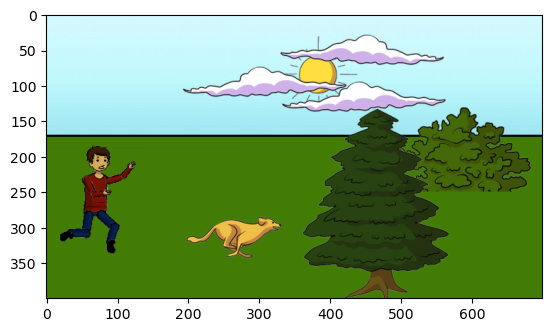

The Question is : How many clouds in the sky?
The Answer is : 3


In [67]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import os

row_no = 10
image_name = df_val.iloc[row_no]['Image_path']  #helps in plotting the image and the address using the annotation dataframe
image = Image.open(os.path.join(image_name))
print("Image path: " + image_name)
print("Image size: " + str(np.asarray(image).shape))
plt.imshow(image)
plt.show()

print("The Question is : " +df_val.iloc[row_no]["question"])
print("The Answer is : " +df_val.iloc[row_no]["multiple_choice_answer"])


The Question is : How many balls?
The Answer is : 1


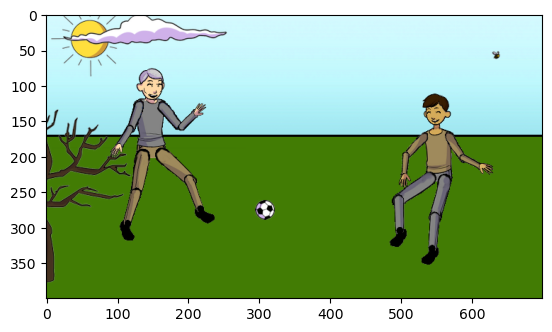

1/1 [==============================] - 2s 2s/step


In [68]:
import tensorflow as tf

random_number = 25
df_val['question'].iloc[5]
print("The Question is : " +df_val['question'].iloc[random_number])
print("The Answer is : " +df_val['multiple_choice_answer'].iloc[random_number])
questn = np.asarray([convert_to_numbers(ques_equivate_len(df_val['question'].iloc[random_number].lower().split(" ")))])

image_name = df_val.iloc[random_number]['Image_path']
image = Image.open(os.path.join(image_name))
plt.imshow(image)
plt.show()

image_name = df_val.iloc[random_number]['Image_path']
image = read_image(image_name)
img1 = VGG16Model.predict(image)

The Question is : How many teapots do you see?
The Answer is : 1


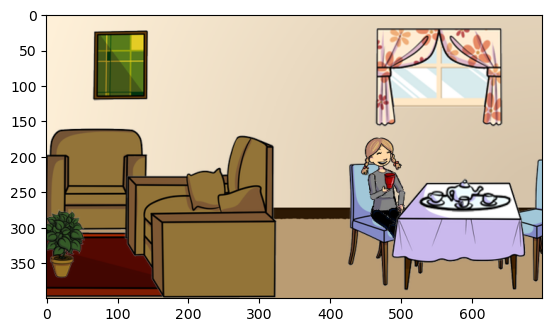

1/1 [==============================] - 0s 450ms/step


In [69]:
import tensorflow as tf

random_number = 30
df_val['question'].iloc[5]
print("The Question is : " +df_val['question'].iloc[random_number])
print("The Answer is : " +df_val['multiple_choice_answer'].iloc[random_number])
questn = np.asarray([convert_to_numbers(ques_equivate_len(df_val['question'].iloc[random_number].lower().split(" ")))])

image_name = df_val.iloc[random_number]['Image_path']
image = Image.open(os.path.join(image_name))
plt.imshow(image)
plt.show()

image_name = df_val.iloc[random_number]['Image_path']
image = read_image(image_name)
img1 = VGG16Model.predict(image)

The Question is : How many slides?
The Answer is : 1


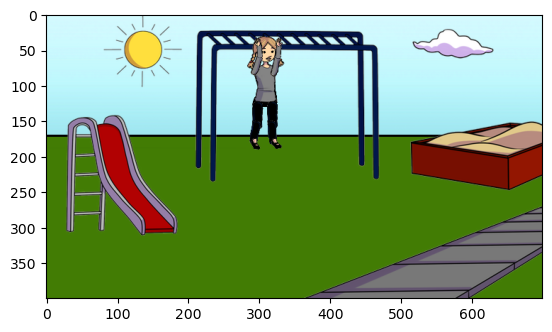

1/1 [==============================] - 0s 455ms/step


In [70]:
import tensorflow as tf

random_number = 200
df_val['question'].iloc[5]
print("The Question is : " +df_val['question'].iloc[random_number])
print("The Answer is : " +df_val['multiple_choice_answer'].iloc[random_number])
questn = np.asarray([convert_to_numbers(ques_equivate_len(df_val['question'].iloc[random_number].lower().split(" ")))])

image_name = df_val.iloc[random_number]['Image_path']
image = Image.open(os.path.join(image_name))
plt.imshow(image)
plt.show()

image_name = df_val.iloc[random_number]['Image_path']
image = read_image(image_name)
img1 = VGG16Model.predict(image)


The Question is : How many butterflies are there?
The Answer is : 2


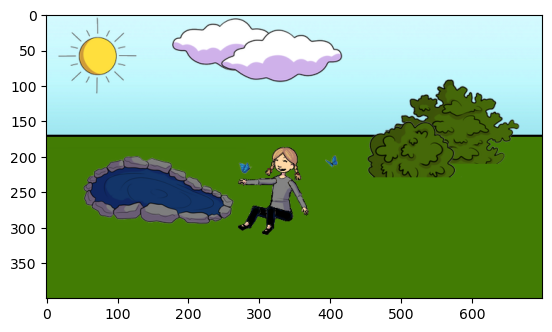

1/1 [==============================] - 0s 315ms/step


In [71]:
import tensorflow as tf

random_number = 221
df_val['question'].iloc[5]
print("The Question is : " +df_val['question'].iloc[random_number])
print("The Answer is : " +df_val['multiple_choice_answer'].iloc[random_number])
questn = np.asarray([convert_to_numbers(ques_equivate_len(df_val['question'].iloc[random_number].lower().split(" ")))])

image_name = df_val.iloc[random_number]['Image_path']
image = Image.open(os.path.join(image_name))
plt.imshow(image)
plt.show()

image_name = df_val.iloc[random_number]['Image_path']
image = read_image(image_name)
img1 = VGG16Model.predict(image)

The Question is : How many dogs are in this scene?
The Answer is : 2


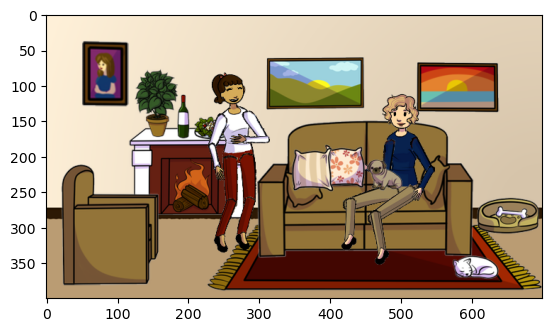

1/1 [==============================] - 0s 378ms/step


In [72]:
import tensorflow as tf

random_number = 121
df_val['question'].iloc[5]
print("The Question is : " +df_val['question'].iloc[random_number])
print("The Answer is : " +df_val['multiple_choice_answer'].iloc[random_number])
questn = np.asarray([convert_to_numbers(ques_equivate_len(df_val['question'].iloc[random_number].lower().split(" ")))])

image_name = df_val.iloc[random_number]['Image_path']
image = Image.open(os.path.join(image_name))
plt.imshow(image)
plt.show()

image_name = df_val.iloc[random_number]['Image_path']
image = read_image(image_name)
img1 = VGG16Model.predict(image)

The Question is : How many bottles are on the table?
The Answer is : 2


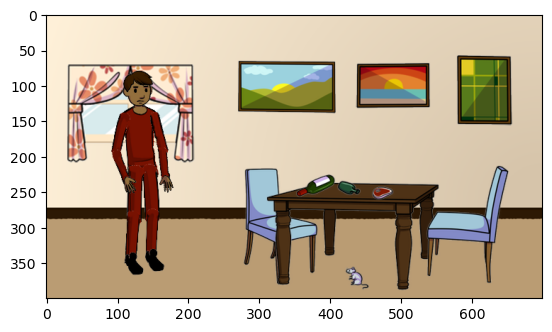

1/1 [==============================] - 0s 309ms/step


In [73]:
import tensorflow as tf

random_number = 300
df_val['question'].iloc[5]
print("The Question is : " +df_val['question'].iloc[random_number])
print("The Answer is : " +df_val['multiple_choice_answer'].iloc[random_number])
questn = np.asarray([convert_to_numbers(ques_equivate_len(df_val['question'].iloc[random_number].lower().split(" ")))])

image_name = df_val.iloc[random_number]['Image_path']
image = Image.open(os.path.join(image_name))
plt.imshow(image)
plt.show()

image_name = df_val.iloc[random_number]['Image_path']
image = read_image(image_name)
img1 = VGG16Model.predict(image)

The Question is : How many deer?
The Answer is : 2


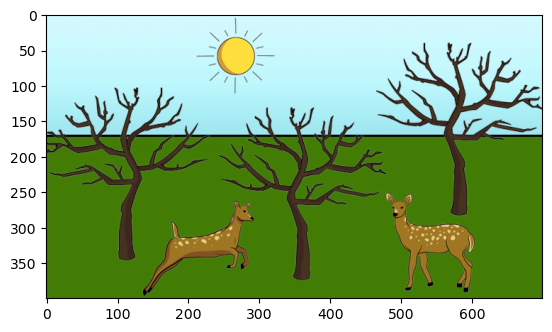

1/1 [==============================] - 0s 427ms/step


In [74]:
import tensorflow as tf

random_number = 331
df_val['question'].iloc[5]
print("The Question is : " +df_val['question'].iloc[random_number])
print("The Answer is : " +df_val['multiple_choice_answer'].iloc[random_number])
questn = np.asarray([convert_to_numbers(ques_equivate_len(df_val['question'].iloc[random_number].lower().split(" ")))])

image_name = df_val.iloc[random_number]['Image_path']
image = Image.open(os.path.join(image_name))
plt.imshow(image)
plt.show()

image_name = df_val.iloc[random_number]['Image_path']
image = read_image(image_name)
img1 = VGG16Model.predict(image)

The Question is : How many birds?
The Answer is : 2


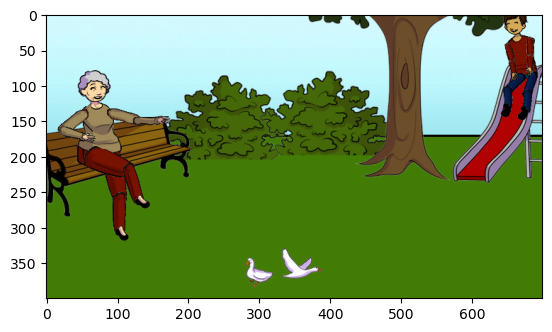

1/1 [==============================] - 0s 478ms/step


In [75]:
import tensorflow as tf

random_number = 550
df_val['question'].iloc[5]
print("The Question is : " +df_val['question'].iloc[random_number])
print("The Answer is : " +df_val['multiple_choice_answer'].iloc[random_number])
questn = np.asarray([convert_to_numbers(ques_equivate_len(df_val['question'].iloc[random_number].lower().split(" ")))])

image_name = df_val.iloc[random_number]['Image_path']
image = Image.open(os.path.join(image_name))
plt.imshow(image)
plt.show()

image_name = df_val.iloc[random_number]['Image_path']
image = read_image(image_name)
img1 = VGG16Model.predict(image)

The Question is : How many mushrooms are in the park?
The Answer is : 3


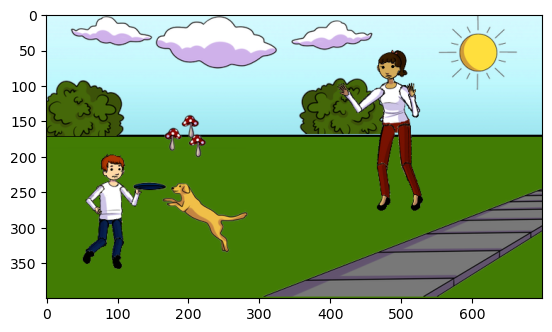

1/1 [==============================] - 0s 439ms/step


In [76]:
import tensorflow as tf

random_number = 600
df_val['question'].iloc[5]
print("The Question is : " +df_val['question'].iloc[random_number])
print("The Answer is : " +df_val['multiple_choice_answer'].iloc[random_number])
questn = np.asarray([convert_to_numbers(ques_equivate_len(df_val['question'].iloc[random_number].lower().split(" ")))])

image_name = df_val.iloc[random_number]['Image_path']
image = Image.open(os.path.join(image_name))
plt.imshow(image)
plt.show()

image_name = df_val.iloc[random_number]['Image_path']
image = read_image(image_name)
img1 = VGG16Model.predict(image)

The Question is : How many children are around?
The Answer is : 1


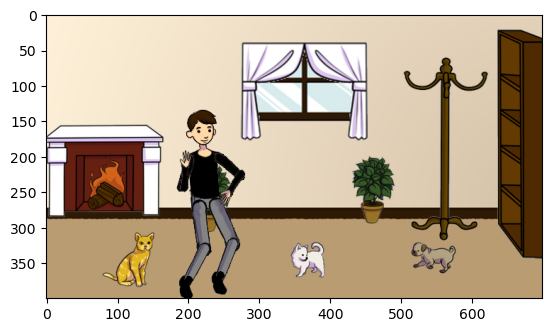

1/1 [==============================] - 0s 432ms/step


In [77]:
import tensorflow as tf

random_number = 621
df_val['question'].iloc[5]
print("The Question is : " +df_val['question'].iloc[random_number])
print("The Answer is : " +df_val['multiple_choice_answer'].iloc[random_number])
questn = np.asarray([convert_to_numbers(ques_equivate_len(df_val['question'].iloc[random_number].lower().split(" ")))])

image_name = df_val.iloc[random_number]['Image_path']
image = Image.open(os.path.join(image_name))
plt.imshow(image)
plt.show()

image_name = df_val.iloc[random_number]['Image_path']
image = read_image(image_name)
img1 = VGG16Model.predict(image)

The Question is : How many paintings?
The Answer is : 2


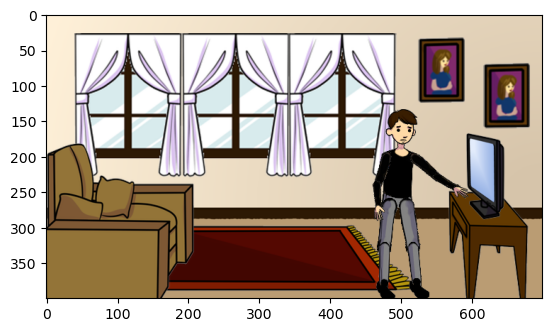

1/1 [==============================] - 0s 437ms/step


In [78]:
import tensorflow as tf

random_number = 711
df_val['question'].iloc[5]
print("The Question is : " +df_val['question'].iloc[random_number])
print("The Answer is : " +df_val['multiple_choice_answer'].iloc[random_number])
questn = np.asarray([convert_to_numbers(ques_equivate_len(df_val['question'].iloc[random_number].lower().split(" ")))])

image_name = df_val.iloc[random_number]['Image_path']
image = Image.open(os.path.join(image_name))
plt.imshow(image)
plt.show()

image_name = df_val.iloc[random_number]['Image_path']
image = read_image(image_name)
img1 = VGG16Model.predict(image)

The Question is : How many mammals are in this scene?
The Answer is : 1


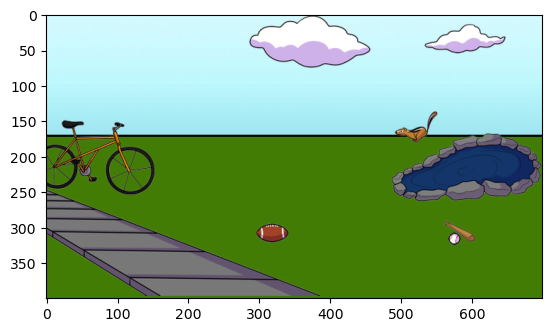

1/1 [==============================] - 1s 538ms/step


In [79]:
import tensorflow as tf

random_number = 800
df_val['question'].iloc[5]
print("The Question is : " +df_val['question'].iloc[random_number])
print("The Answer is : " +df_val['multiple_choice_answer'].iloc[random_number])
questn = np.asarray([convert_to_numbers(ques_equivate_len(df_val['question'].iloc[random_number].lower().split(" ")))])

image_name = df_val.iloc[random_number]['Image_path']
image = Image.open(os.path.join(image_name))
plt.imshow(image)
plt.show()

image_name = df_val.iloc[random_number]['Image_path']
image = read_image(image_name)
img1 = VGG16Model.predict(image)

The Question is : How many bars are on the monkey bar set?
The Answer is : 11


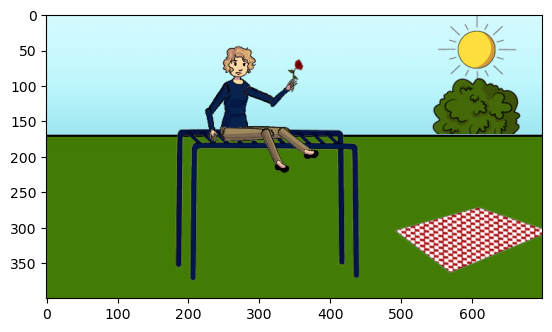

1/1 [==============================] - 0s 232ms/step


In [80]:
import tensorflow as tf

random_number = 831
df_val['question'].iloc[5]
print("The Question is : " +df_val['question'].iloc[random_number])
print("The Answer is : " +df_val['multiple_choice_answer'].iloc[random_number])
questn = np.asarray([convert_to_numbers(ques_equivate_len(df_val['question'].iloc[random_number].lower().split(" ")))])

image_name = df_val.iloc[random_number]['Image_path']
image = Image.open(os.path.join(image_name))
plt.imshow(image)
plt.show()

image_name = df_val.iloc[random_number]['Image_path']
image = read_image(image_name)
img1 = VGG16Model.predict(image)

The Question is : How many doors in the room?
The Answer is : 1


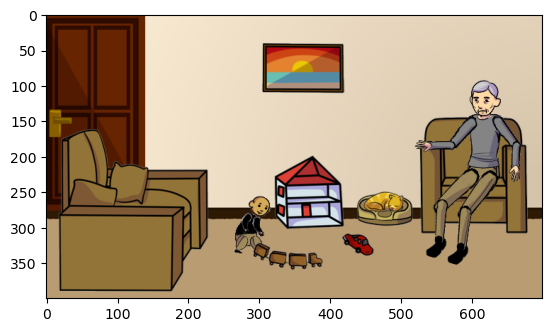

1/1 [==============================] - 0s 307ms/step


In [81]:
import tensorflow as tf

random_number = 899
df_val['question'].iloc[5]
print("The Question is : " +df_val['question'].iloc[random_number])
print("The Answer is : " +df_val['multiple_choice_answer'].iloc[random_number])
questn = np.asarray([convert_to_numbers(ques_equivate_len(df_val['question'].iloc[random_number].lower().split(" ")))])

image_name = df_val.iloc[random_number]['Image_path']
image = Image.open(os.path.join(image_name))
plt.imshow(image)
plt.show()

image_name = df_val.iloc[random_number]['Image_path']
image = read_image(image_name)
img1 = VGG16Model.predict(image)

The Question is : How many birds?
The Answer is : 1


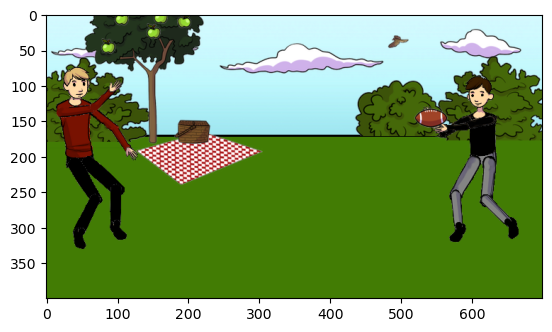

1/1 [==============================] - 0s 455ms/step


In [82]:
import tensorflow as tf

random_number = 955
df_val['question'].iloc[5]
print("The Question is : " +df_val['question'].iloc[random_number])
print("The Answer is : " +df_val['multiple_choice_answer'].iloc[random_number])
questn = np.asarray([convert_to_numbers(ques_equivate_len(df_val['question'].iloc[random_number].lower().split(" ")))])

image_name = df_val.iloc[random_number]['Image_path']
image = Image.open(os.path.join(image_name))
plt.imshow(image)
plt.show()

image_name = df_val.iloc[random_number]['Image_path']
image = read_image(image_name)
img1 = VGG16Model.predict(image)

The Question is : How many TV's are on?
The Answer is : 0


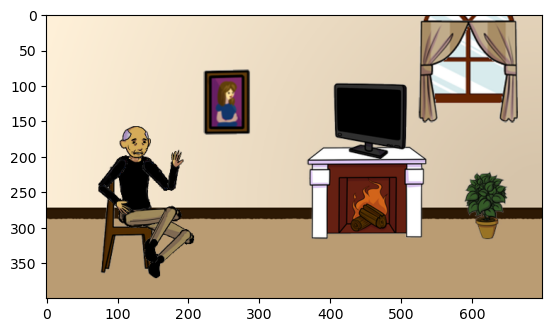

1/1 [==============================] - 0s 449ms/step


In [83]:
import tensorflow as tf

random_number = 1001
df_val['question'].iloc[5]
print("The Question is : " +df_val['question'].iloc[random_number])
print("The Answer is : " +df_val['multiple_choice_answer'].iloc[random_number])
questn = np.asarray([convert_to_numbers(ques_equivate_len(df_val['question'].iloc[random_number].lower().split(" ")))])

image_name = df_val.iloc[random_number]['Image_path']
image = Image.open(os.path.join(image_name))
plt.imshow(image)
plt.show()

image_name = df_val.iloc[random_number]['Image_path']
image = read_image(image_name)
img1 = VGG16Model.predict(image)

The Question is : How many flower are seen?
The Answer is : 2


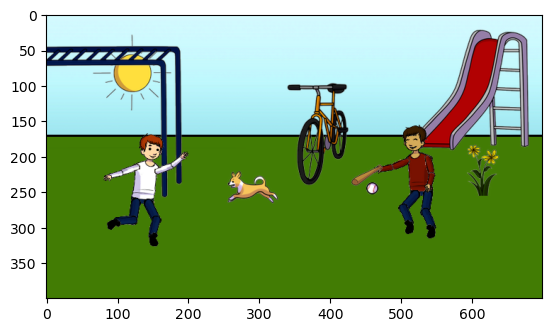

1/1 [==============================] - 0s 411ms/step


In [84]:
import tensorflow as tf

random_number = 1020
df_val['question'].iloc[5]
print("The Question is : " +df_val['question'].iloc[random_number])
print("The Answer is : " +df_val['multiple_choice_answer'].iloc[random_number])
questn = np.asarray([convert_to_numbers(ques_equivate_len(df_val['question'].iloc[random_number].lower().split(" ")))])

image_name = df_val.iloc[random_number]['Image_path']
image = Image.open(os.path.join(image_name))
plt.imshow(image)
plt.show()

image_name = df_val.iloc[random_number]['Image_path']
image = read_image(image_name)
img1 = VGG16Model.predict(image)

The Question is : How many balls?
The Answer is : 1


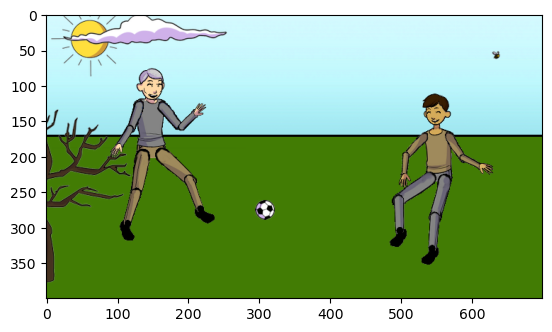

1/1 [==============================] - 0s 329ms/step


In [85]:
import tensorflow as tf

random_number = 25
df_val['question'].iloc[5]
print("The Question is : " +df_val['question'].iloc[random_number])
print("The Answer is : " +df_val['multiple_choice_answer'].iloc[random_number])
questn = np.asarray([convert_to_numbers(ques_equivate_len(df_val['question'].iloc[random_number].lower().split(" ")))])

image_name = df_val.iloc[random_number]['Image_path']
image = Image.open(os.path.join(image_name))
plt.imshow(image)
plt.show()

image_name = df_val.iloc[random_number]['Image_path']
image = read_image(image_name)
img1 = VGG16Model.predict(image)

The Question is : How many lily pads are in the pond?
The Answer is : 4


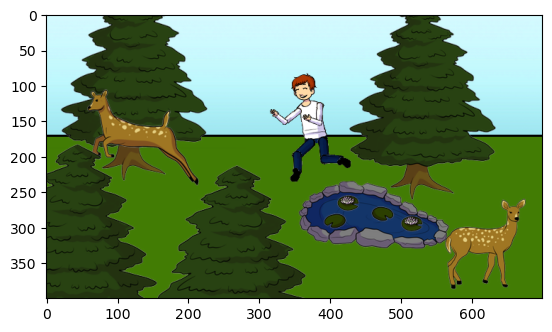

1/1 [==============================] - 0s 326ms/step


In [86]:
import tensorflow as tf

random_number = 1150
df_val['question'].iloc[5]
print("The Question is : " +df_val['question'].iloc[random_number])
print("The Answer is : " +df_val['multiple_choice_answer'].iloc[random_number])
questn = np.asarray([convert_to_numbers(ques_equivate_len(df_val['question'].iloc[random_number].lower().split(" ")))])

image_name = df_val.iloc[random_number]['Image_path']
image = Image.open(os.path.join(image_name))
plt.imshow(image)
plt.show()

image_name = df_val.iloc[random_number]['Image_path']
image = read_image(image_name)
img1 = VGG16Model.predict(image)

The Question is : How many rocks surround the pond?
The Answer is : 18


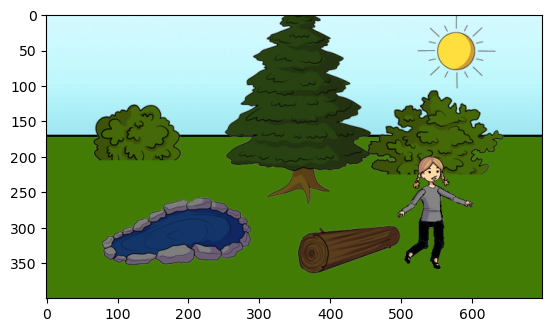

1/1 [==============================] - 1s 612ms/step


In [87]:
import tensorflow as tf

random_number = 1301
df_val['question'].iloc[5]
print("The Question is : " +df_val['question'].iloc[random_number])
print("The Answer is : " +df_val['multiple_choice_answer'].iloc[random_number])
questn = np.asarray([convert_to_numbers(ques_equivate_len(df_val['question'].iloc[random_number].lower().split(" ")))])

image_name = df_val.iloc[random_number]['Image_path']
image = Image.open(os.path.join(image_name))
plt.imshow(image)
plt.show()

image_name = df_val.iloc[random_number]['Image_path']
image = read_image(image_name)
img1 = VGG16Model.predict(image)

The Question is : How many trees?
The Answer is : 1


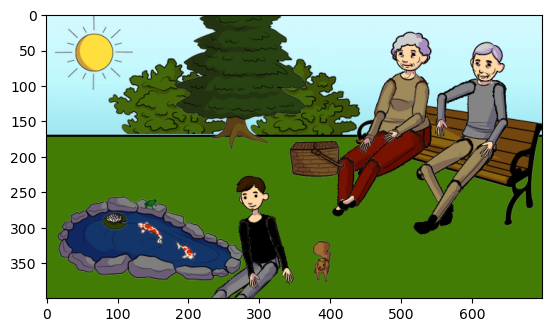

1/1 [==============================] - 0s 274ms/step


In [89]:
import tensorflow as tf

random_number = 1350
df_val['question'].iloc[5]
print("The Question is : " +df_val['question'].iloc[random_number])
print("The Answer is : " +df_val['multiple_choice_answer'].iloc[random_number])
questn = np.asarray([convert_to_numbers(ques_equivate_len(df_val['question'].iloc[random_number].lower().split(" ")))])

image_name = df_val.iloc[random_number]['Image_path']
image = Image.open(os.path.join(image_name))
plt.imshow(image)
plt.show()

image_name = df_val.iloc[random_number]['Image_path']
image = read_image(image_name)
img1 = VGG16Model.predict(image)

The Question is : How many people?
The Answer is : 2


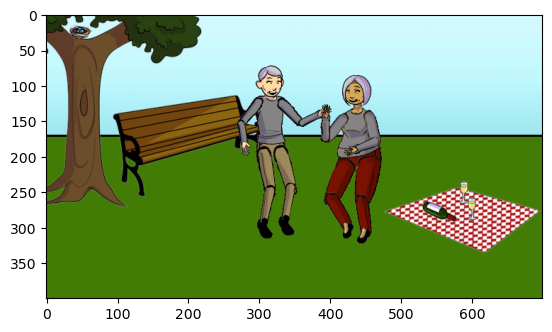

1/1 [==============================] - 0s 272ms/step


In [90]:
import tensorflow as tf

random_number = 1499
df_val['question'].iloc[5]
print("The Question is : " +df_val['question'].iloc[random_number])
print("The Answer is : " +df_val['multiple_choice_answer'].iloc[random_number])
questn = np.asarray([convert_to_numbers(ques_equivate_len(df_val['question'].iloc[random_number].lower().split(" ")))])

image_name = df_val.iloc[random_number]['Image_path']
image = Image.open(os.path.join(image_name))
plt.imshow(image)
plt.show()

image_name = df_val.iloc[random_number]['Image_path']
image = read_image(image_name)
img1 = VGG16Model.predict(image)

The Question is : How many logs are on the ground?
The Answer is : 2


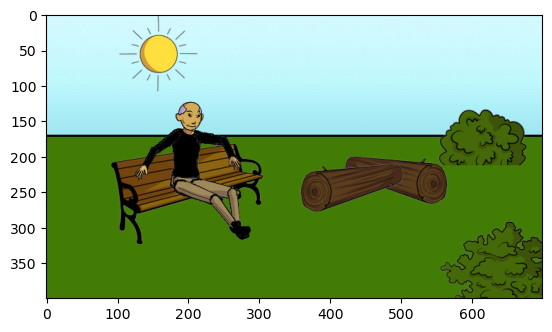

1/1 [==============================] - 0s 425ms/step


In [91]:
import tensorflow as tf

random_number = 1590
df_val['question'].iloc[5]
print("The Question is : " +df_val['question'].iloc[random_number])
print("The Answer is : " +df_val['multiple_choice_answer'].iloc[random_number])
questn = np.asarray([convert_to_numbers(ques_equivate_len(df_val['question'].iloc[random_number].lower().split(" ")))])

image_name = df_val.iloc[random_number]['Image_path']
image = Image.open(os.path.join(image_name))
plt.imshow(image)
plt.show()

image_name = df_val.iloc[random_number]['Image_path']
image = read_image(image_name)
img1 = VGG16Model.predict(image)

The Question is : How many tea cups?
The Answer is : 3


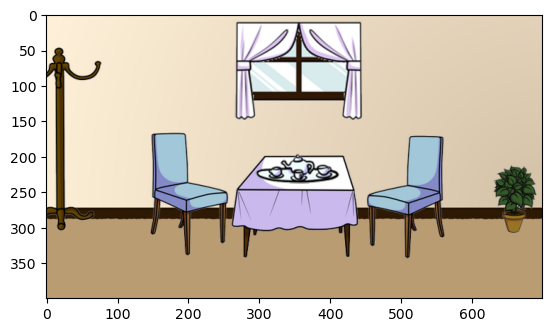

1/1 [==============================] - 0s 441ms/step


In [92]:
import tensorflow as tf

random_number = 1631
df_val['question'].iloc[5]
print("The Question is : " +df_val['question'].iloc[random_number])
print("The Answer is : " +df_val['multiple_choice_answer'].iloc[random_number])
questn = np.asarray([convert_to_numbers(ques_equivate_len(df_val['question'].iloc[random_number].lower().split(" ")))])

image_name = df_val.iloc[random_number]['Image_path']
image = Image.open(os.path.join(image_name))
plt.imshow(image)
plt.show()

image_name = df_val.iloc[random_number]['Image_path']
image = read_image(image_name)
img1 = VGG16Model.predict(image)

The Question is : How many windows?
The Answer is : 2


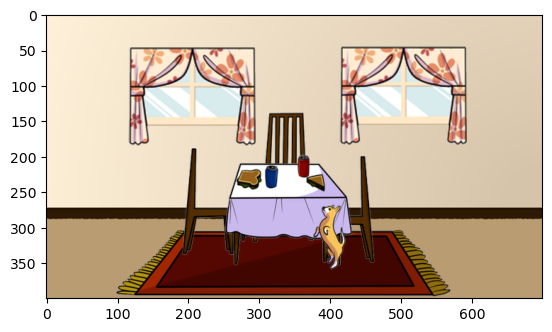

1/1 [==============================] - 0s 455ms/step


In [93]:
import tensorflow as tf

random_number = 1799
df_val['question'].iloc[5]
print("The Question is : " +df_val['question'].iloc[random_number])
print("The Answer is : " +df_val['multiple_choice_answer'].iloc[random_number])
questn = np.asarray([convert_to_numbers(ques_equivate_len(df_val['question'].iloc[random_number].lower().split(" ")))])

image_name = df_val.iloc[random_number]['Image_path']
image = Image.open(os.path.join(image_name))
plt.imshow(image)
plt.show()

image_name = df_val.iloc[random_number]['Image_path']
image = read_image(image_name)
img1 = VGG16Model.predict(image)

The Question is : How many yellow pillows are on the couch?
The Answer is : 1


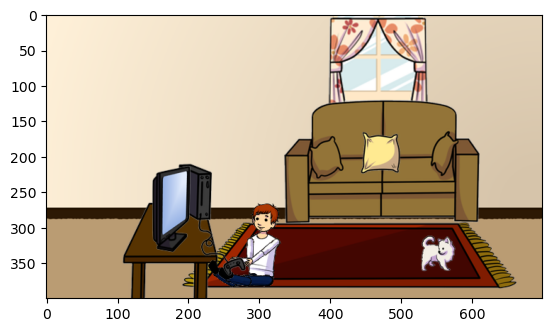

1/1 [==============================] - 0s 317ms/step


In [95]:
import tensorflow as tf

random_number = 2000
df_val['question'].iloc[5]
print("The Question is : " +df_val['question'].iloc[random_number])
print("The Answer is : " +df_val['multiple_choice_answer'].iloc[random_number])
questn = np.asarray([convert_to_numbers(ques_equivate_len(df_val['question'].iloc[random_number].lower().split(" ")))])

image_name = df_val.iloc[random_number]['Image_path']
image = Image.open(os.path.join(image_name))
plt.imshow(image)
plt.show()

image_name = df_val.iloc[random_number]['Image_path']
image = read_image(image_name)
img1 = VGG16Model.predict(image)

The Question is : How many squirrels are there?
The Answer is : 2


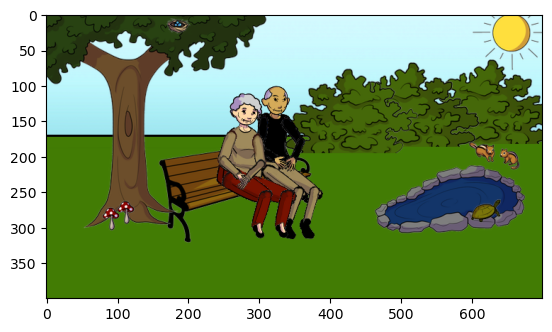

1/1 [==============================] - 0s 449ms/step


In [96]:
import tensorflow as tf

random_number = 2022
df_val['question'].iloc[5]
print("The Question is : " +df_val['question'].iloc[random_number])
print("The Answer is : " +df_val['multiple_choice_answer'].iloc[random_number])
questn = np.asarray([convert_to_numbers(ques_equivate_len(df_val['question'].iloc[random_number].lower().split(" ")))])

image_name = df_val.iloc[random_number]['Image_path']
image = Image.open(os.path.join(image_name))
plt.imshow(image)
plt.show()

image_name = df_val.iloc[random_number]['Image_path']
image = read_image(image_name)
img1 = VGG16Model.predict(image)

The Question is : How many different kinds of animals are there?
The Answer is : 4


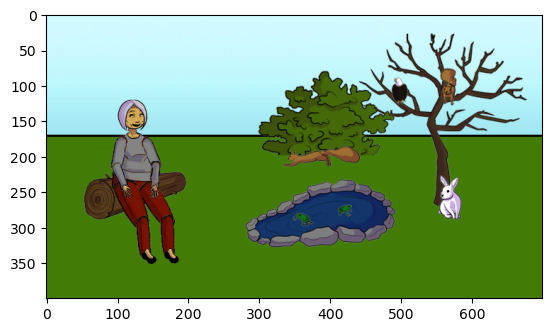

1/1 [==============================] - 0s 424ms/step


In [97]:
import tensorflow as tf

random_number = 2100
df_val['question'].iloc[5]
print("The Question is : " +df_val['question'].iloc[random_number])
print("The Answer is : " +df_val['multiple_choice_answer'].iloc[random_number])
questn = np.asarray([convert_to_numbers(ques_equivate_len(df_val['question'].iloc[random_number].lower().split(" ")))])

image_name = df_val.iloc[random_number]['Image_path']
image = Image.open(os.path.join(image_name))
plt.imshow(image)
plt.show()

image_name = df_val.iloc[random_number]['Image_path']
image = read_image(image_name)
img1 = VGG16Model.predict(image)

The Question is : How many balls?
The Answer is : 1


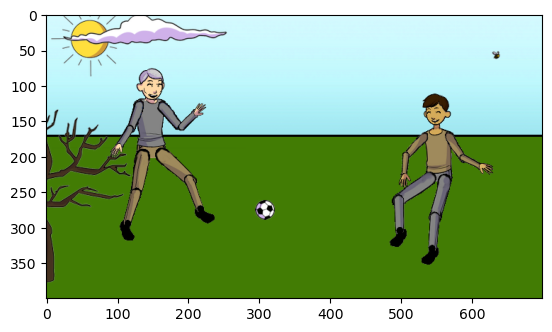

1/1 [==============================] - 0s 481ms/step


In [158]:
import tensorflow as tf

random_number = 25
df_val['question'].iloc[25]
print("The Question is : " +df_val['question'].iloc[random_number])
print("The Answer is : " +df_val['multiple_choice_answer'].iloc[random_number])
questn = np.asarray([convert_to_numbers(ques_equivate_len(df_val['question'].iloc[random_number].lower().split(" ")))])

image_name = df_val.iloc[random_number]['Image_path']
image = Image.open(os.path.join(image_name))
plt.imshow(image)
plt.show()

image_name = df_val.iloc[random_number]['Image_path']
image = read_image(image_name)
img1 = VGG16Model.predict(image)

## Attention map between answer and question words:

In [140]:
import seaborn as sns

In [141]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [142]:
def Attention_map(similarity, str_arr, cmap = "RdPu"):
  DataFrame = pd.DataFrame(similarity)
  DataFrame.columns = str_arr
  DataFrame.index = str_arr
  fig, ax = plt.subplots(figsize=(8,5))
  sns.heatmap(DataFrame, cmap=cmap)

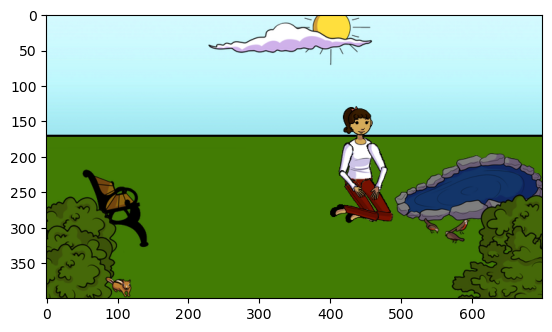

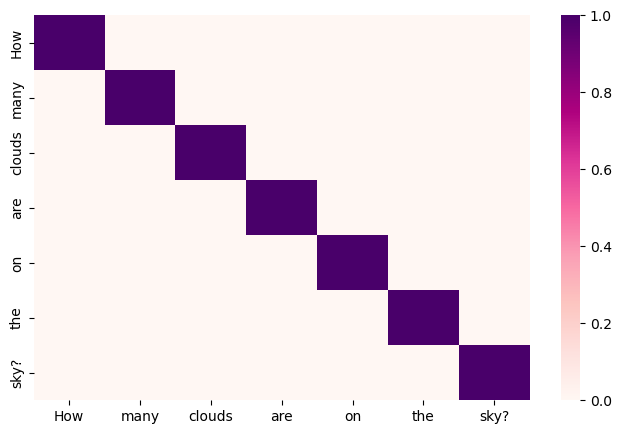

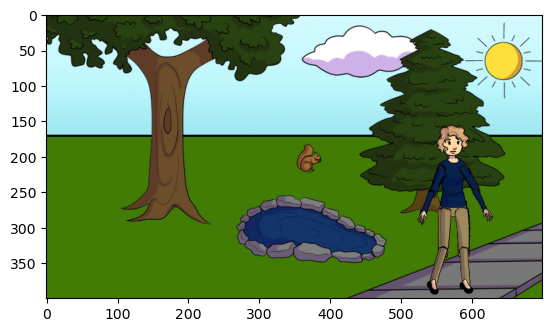

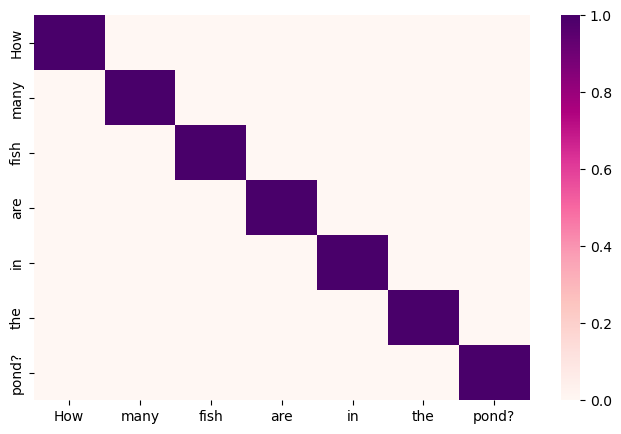

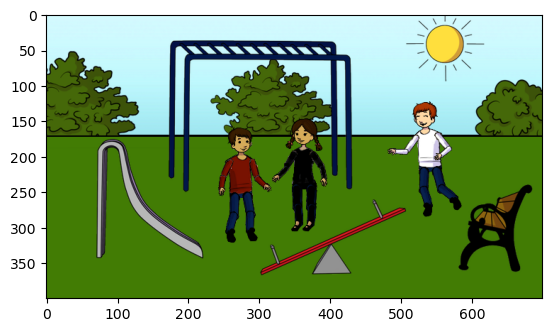

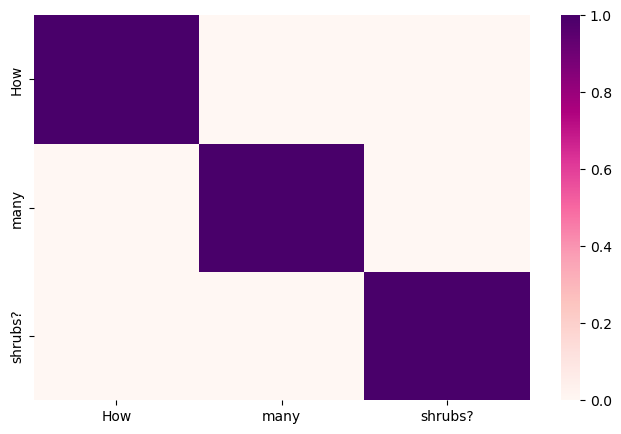

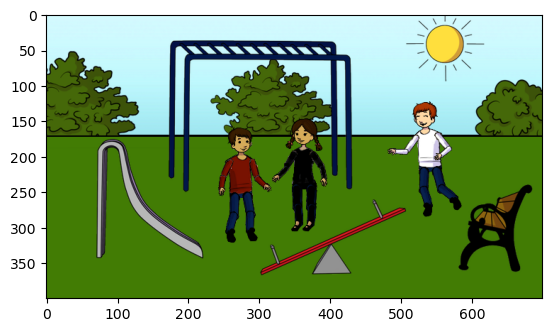

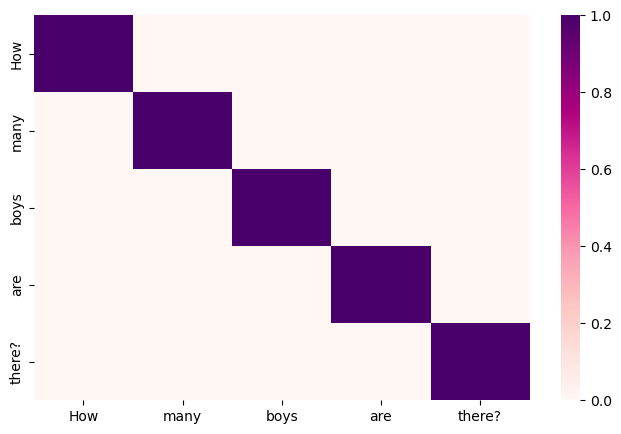

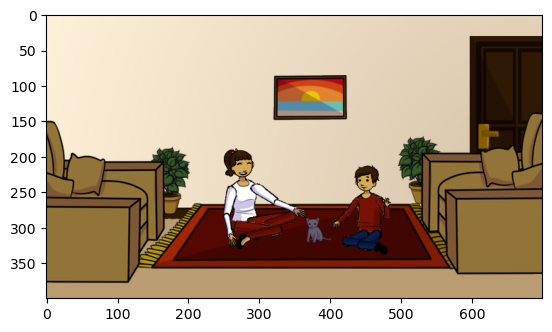

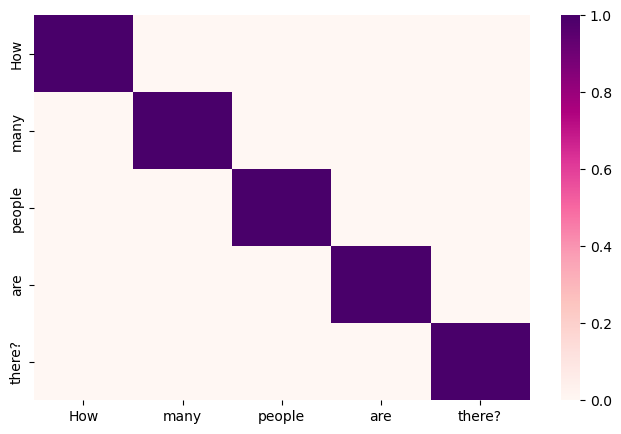

In [143]:
for i in range(20,25):
  string_txt=df_train['question'].iloc[i].split()
  str_arr = [headline[:20] for headline in string_txt]
  vect = CountVectorizer().fit_transform(string_txt)
  arr = vect.toarray()
  image = cv2.cvtColor(cv2.imread(df_train['Image_path'].iloc[i]), cv2.COLOR_BGR2RGB)
  plt.imshow(image)
  Attention_map(cosine_similarity(arr), str_arr)
  plt.show()

# HeatMap for imput image:

In [159]:
modelsum = InceptionV3(weights='imagenet')
modelsum.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_16 (InputLayer)          [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_752 (Conv2D)            (None, 149, 149, 32  864         ['input_16[0][0]']               
                                )                                                                 
                                                                                                  
 batch_normalization_752 (Batch  (None, 149, 149, 32  96         ['conv2d_752[0][0]']             
 Normalization)                 )                                                      

 conv2d_763 (Conv2D)            (None, 35, 35, 32)   6144        ['average_pooling2d_72[0][0]']   
                                                                                                  
 batch_normalization_757 (Batch  (None, 35, 35, 64)  192         ['conv2d_757[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_759 (Batch  (None, 35, 35, 64)  192         ['conv2d_759[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_762 (Batch  (None, 35, 35, 96)  288         ['conv2d_762[0][0]']             
 Normalization)                                                                                   
          

                                                                                                  
 conv2d_774 (Conv2D)            (None, 35, 35, 64)   18432       ['mixed1[0][0]']                 
                                                                                                  
 batch_normalization_774 (Batch  (None, 35, 35, 64)  192         ['conv2d_774[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_774 (Activation)    (None, 35, 35, 64)   0           ['batch_normalization_774[0][0]']
                                                                                                  
 conv2d_772 (Conv2D)            (None, 35, 35, 48)   13824       ['mixed1[0][0]']                 
                                                                                                  
 conv2d_77

                                                                                                  
 activation_781 (Activation)    (None, 17, 17, 96)   0           ['batch_normalization_781[0][0]']
                                                                                                  
 max_pooling2d_34 (MaxPooling2D  (None, 17, 17, 288)  0          ['mixed2[0][0]']                 
 )                                                                                                
                                                                                                  
 mixed3 (Concatenate)           (None, 17, 17, 768)  0           ['activation_778[0][0]',         
                                                                  'activation_781[0][0]',         
                                                                  'max_pooling2d_34[0][0]']       
                                                                                                  
 conv2d_78

 mixed4 (Concatenate)           (None, 17, 17, 768)  0           ['activation_782[0][0]',         
                                                                  'activation_785[0][0]',         
                                                                  'activation_790[0][0]',         
                                                                  'activation_791[0][0]']         
                                                                                                  
 conv2d_796 (Conv2D)            (None, 17, 17, 160)  122880      ['mixed4[0][0]']                 
                                                                                                  
 batch_normalization_796 (Batch  (None, 17, 17, 160)  480        ['conv2d_796[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activatio

 conv2d_806 (Conv2D)            (None, 17, 17, 160)  122880      ['mixed5[0][0]']                 
                                                                                                  
 batch_normalization_806 (Batch  (None, 17, 17, 160)  480        ['conv2d_806[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_806 (Activation)    (None, 17, 17, 160)  0           ['batch_normalization_806[0][0]']
                                                                                                  
 conv2d_807 (Conv2D)            (None, 17, 17, 160)  179200      ['activation_806[0][0]']         
                                                                                                  
 batch_normalization_807 (Batch  (None, 17, 17, 160)  480        ['conv2d_807[0][0]']             
 Normaliza

 activation_816 (Activation)    (None, 17, 17, 192)  0           ['batch_normalization_816[0][0]']
                                                                                                  
 conv2d_817 (Conv2D)            (None, 17, 17, 192)  258048      ['activation_816[0][0]']         
                                                                                                  
 batch_normalization_817 (Batch  (None, 17, 17, 192)  576        ['conv2d_817[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_817 (Activation)    (None, 17, 17, 192)  0           ['batch_normalization_817[0][0]']
                                                                                                  
 conv2d_813 (Conv2D)            (None, 17, 17, 192)  147456      ['mixed6[0][0]']                 
          

 Normalization)                                                                                   
                                                                                                  
 activation_825 (Activation)    (None, 17, 17, 192)  0           ['batch_normalization_825[0][0]']
                                                                                                  
 conv2d_822 (Conv2D)            (None, 17, 17, 192)  147456      ['mixed7[0][0]']                 
                                                                                                  
 conv2d_826 (Conv2D)            (None, 17, 17, 192)  258048      ['activation_825[0][0]']         
                                                                                                  
 batch_normalization_822 (Batch  (None, 17, 17, 192)  576        ['conv2d_822[0][0]']             
 Normalization)                                                                                   
          

 Normalization)                                                                                   
                                                                                                  
 conv2d_836 (Conv2D)            (None, 8, 8, 192)    245760      ['average_pooling2d_79[0][0]']   
                                                                                                  
 batch_normalization_828 (Batch  (None, 8, 8, 320)   960         ['conv2d_828[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_830 (Activation)    (None, 8, 8, 384)    0           ['batch_normalization_830[0][0]']
                                                                                                  
 activation_831 (Activation)    (None, 8, 8, 384)    0           ['batch_normalization_831[0][0]']
          

                                                                                                  
 activation_839 (Activation)    (None, 8, 8, 384)    0           ['batch_normalization_839[0][0]']
                                                                                                  
 activation_840 (Activation)    (None, 8, 8, 384)    0           ['batch_normalization_840[0][0]']
                                                                                                  
 activation_843 (Activation)    (None, 8, 8, 384)    0           ['batch_normalization_843[0][0]']
                                                                                                  
 activation_844 (Activation)    (None, 8, 8, 384)    0           ['batch_normalization_844[0][0]']
                                                                                                  
 batch_normalization_845 (Batch  (None, 8, 8, 192)   576         ['conv2d_845[0][0]']             
 Normaliza

In [160]:
conda install opencv

Solving environment: done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


In [161]:
import cv2
import tensorflow.keras.backend as K
from tensorflow.keras.preprocessing import image

In [162]:
modelsum.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_16 (InputLayer)          [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_752 (Conv2D)            (None, 149, 149, 32  864         ['input_16[0][0]']               
                                )                                                                 
                                                                                                  
 batch_normalization_752 (Batch  (None, 149, 149, 32  96         ['conv2d_752[0][0]']             
 Normalization)                 )                                                      

 conv2d_763 (Conv2D)            (None, 35, 35, 32)   6144        ['average_pooling2d_72[0][0]']   
                                                                                                  
 batch_normalization_757 (Batch  (None, 35, 35, 64)  192         ['conv2d_757[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_759 (Batch  (None, 35, 35, 64)  192         ['conv2d_759[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_762 (Batch  (None, 35, 35, 96)  288         ['conv2d_762[0][0]']             
 Normalization)                                                                                   
          

                                                                                                  
 conv2d_774 (Conv2D)            (None, 35, 35, 64)   18432       ['mixed1[0][0]']                 
                                                                                                  
 batch_normalization_774 (Batch  (None, 35, 35, 64)  192         ['conv2d_774[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_774 (Activation)    (None, 35, 35, 64)   0           ['batch_normalization_774[0][0]']
                                                                                                  
 conv2d_772 (Conv2D)            (None, 35, 35, 48)   13824       ['mixed1[0][0]']                 
                                                                                                  
 conv2d_77

                                                                                                  
 activation_781 (Activation)    (None, 17, 17, 96)   0           ['batch_normalization_781[0][0]']
                                                                                                  
 max_pooling2d_34 (MaxPooling2D  (None, 17, 17, 288)  0          ['mixed2[0][0]']                 
 )                                                                                                
                                                                                                  
 mixed3 (Concatenate)           (None, 17, 17, 768)  0           ['activation_778[0][0]',         
                                                                  'activation_781[0][0]',         
                                                                  'max_pooling2d_34[0][0]']       
                                                                                                  
 conv2d_78

 mixed4 (Concatenate)           (None, 17, 17, 768)  0           ['activation_782[0][0]',         
                                                                  'activation_785[0][0]',         
                                                                  'activation_790[0][0]',         
                                                                  'activation_791[0][0]']         
                                                                                                  
 conv2d_796 (Conv2D)            (None, 17, 17, 160)  122880      ['mixed4[0][0]']                 
                                                                                                  
 batch_normalization_796 (Batch  (None, 17, 17, 160)  480        ['conv2d_796[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activatio

 conv2d_806 (Conv2D)            (None, 17, 17, 160)  122880      ['mixed5[0][0]']                 
                                                                                                  
 batch_normalization_806 (Batch  (None, 17, 17, 160)  480        ['conv2d_806[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_806 (Activation)    (None, 17, 17, 160)  0           ['batch_normalization_806[0][0]']
                                                                                                  
 conv2d_807 (Conv2D)            (None, 17, 17, 160)  179200      ['activation_806[0][0]']         
                                                                                                  
 batch_normalization_807 (Batch  (None, 17, 17, 160)  480        ['conv2d_807[0][0]']             
 Normaliza

 activation_816 (Activation)    (None, 17, 17, 192)  0           ['batch_normalization_816[0][0]']
                                                                                                  
 conv2d_817 (Conv2D)            (None, 17, 17, 192)  258048      ['activation_816[0][0]']         
                                                                                                  
 batch_normalization_817 (Batch  (None, 17, 17, 192)  576        ['conv2d_817[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_817 (Activation)    (None, 17, 17, 192)  0           ['batch_normalization_817[0][0]']
                                                                                                  
 conv2d_813 (Conv2D)            (None, 17, 17, 192)  147456      ['mixed6[0][0]']                 
          

 Normalization)                                                                                   
                                                                                                  
 activation_825 (Activation)    (None, 17, 17, 192)  0           ['batch_normalization_825[0][0]']
                                                                                                  
 conv2d_822 (Conv2D)            (None, 17, 17, 192)  147456      ['mixed7[0][0]']                 
                                                                                                  
 conv2d_826 (Conv2D)            (None, 17, 17, 192)  258048      ['activation_825[0][0]']         
                                                                                                  
 batch_normalization_822 (Batch  (None, 17, 17, 192)  576        ['conv2d_822[0][0]']             
 Normalization)                                                                                   
          

 Normalization)                                                                                   
                                                                                                  
 conv2d_836 (Conv2D)            (None, 8, 8, 192)    245760      ['average_pooling2d_79[0][0]']   
                                                                                                  
 batch_normalization_828 (Batch  (None, 8, 8, 320)   960         ['conv2d_828[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_830 (Activation)    (None, 8, 8, 384)    0           ['batch_normalization_830[0][0]']
                                                                                                  
 activation_831 (Activation)    (None, 8, 8, 384)    0           ['batch_normalization_831[0][0]']
          

                                                                                                  
 activation_839 (Activation)    (None, 8, 8, 384)    0           ['batch_normalization_839[0][0]']
                                                                                                  
 activation_840 (Activation)    (None, 8, 8, 384)    0           ['batch_normalization_840[0][0]']
                                                                                                  
 activation_843 (Activation)    (None, 8, 8, 384)    0           ['batch_normalization_843[0][0]']
                                                                                                  
 activation_844 (Activation)    (None, 8, 8, 384)    0           ['batch_normalization_844[0][0]']
                                                                                                  
 batch_normalization_845 (Batch  (None, 8, 8, 192)   576         ['conv2d_845[0][0]']             
 Normaliza

In [164]:
def ImageHeatmaps(images, intensity=0.5, res=299):
  images_ = image.load_img(images, target_size=(299, 299))
  val = image.img_to_array(images_)
  valx = np.expand_dims(val, axis=0)
  valx = preprocess_input(valx)
  predcted_Values = modelsum.predict(valx)
  with tf.GradientTape() as gradValue:
#     print(modelsum.layers)
    ConvLastLayer = modelsum.get_layer('conv2d_845')
    dataiter = tf.keras.models.Model([modelsum.inputs], [modelsum.output, ConvLastLayer.output])
    OutModel, ConvLastLayer = dataiter(valx)
    OutClass = OutModel[:, np.argmax(OutModel[0])]
    Gradient = gradValue.gradient(OutClass, ConvLastLayer)
    pooled_Gradient = K.mean(Gradient, axis=(0, 1, 2))
  ImageHeatmaps = tf.reduce_mean(tf.multiply(pooled_Gradient, ConvLastLayer), axis=-1)
  ImageHeatmaps = np.maximum(ImageHeatmaps, 0)
  ImageHeatmaps /= np.max(ImageHeatmaps)
  ImageHeatmaps = ImageHeatmaps.reshape((1,35,35)).flatten()
  img = cv2.imread(images)
  ImageHeatmaps = cv2.resize(ImageHeatmaps, (img.shape[1], img.shape[0]))
  ImageHeatmaps = cv2.applyColorMap(np.uint8(255*ImageHeatmaps), cv2.COLORMAP_JET)
  img = ImageHeatmaps * intensity + img
  y = cv2.resize(cv2.imread(images), (res, res))
  y = cv2.normalize(y, None, 0, 1.0, cv2.NORM_MINMAX, dtype=cv2.CV_32F)
  plt.imshow(y)
  plt.show()
  x = cv2.resize(img, (res, res))
  x = cv2.normalize(x, None, 0, 1.0, cv2.NORM_MINMAX, dtype=cv2.CV_32F)
  #print(x)
  plt.imshow(x)
  plt.show()
  cv2.imshow('', cv2.resize(cv2.imread(images), (res, res)))
  cv2.imshow('', cv2.resize(img, (res, res)))

ImageHeatmaps(df_val['Image_path'].iloc[25])

1/1 [==============================] - 0s 102ms/step


ValueError: cannot reshape array of size 64 into shape (1,35,35)